# Quickstart

I spent the first 20 minutes on this competition training a quick baseline model and getting familiar with the data format, submission process and so on. I figure it's worth sharing for those wanting to get up and running quickly using fastai :)

This isn't a tutorial - although I do make some suggestions at the bottom of the notebook for directins to explore.

# Setup

Assuming provided files are present. Installing fastai (may need to restart runtime)

In [ ]:
#a=[]
#while(1):
 # a.append('1')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Indabax UG/Passion Fruit Disease Prediction')
!ls

dataset.zip			       passion_prediction1_resnet18_1.csv
Images				       passion_prediction1_resnet18.csv
Images.zip			       passion_prediction1_resnet50_1.csv
passion_1.csv			       passion_prediction2.csv
Passionfruit_quickstart.ipynb	       passion_prediction2_densenet169_1.csv
passion_prediction1.csv		       passion_prediction3.csv
passion_prediction1_densenet121_1.csv  passion_prediction3_densenet169_1.csv
passion_prediction1_densenet169_1.csv  passion_Sample_submission.csv
passion_prediction1_densenet169_2.csv  passion_Test.csv
passion_prediction1_densenet201_1.csv  passion_Train.csv
passion_prediction1_densenet201_2.csv


In [ ]:
 #!cp 'drive/My Drive/Indabax UG Passion Fruit Disease Detection/Images.zip' dataset.zip # I stored it in my drive

In [ ]:
#cp --help

In [ ]:
!unzip -q Images.zip

replace Images/ID_H6X92LTX.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install -qU fastcore fastai

     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 188 kB 15.6 MB/s 


In [ ]:
import fastai
fastai.__version__

'2.4.1'

# Load data and put in dataloaders

Fastai makes it relatively easy to get our training data from the dataframe into a format we can use for training. For now I'm ignoring the bouding box annotations - that's a task for later.

In [ ]:
from fastai.vision.all import *

In [ ]:
import torch
import random

In [ ]:
# Set the seed value all over the place to make this reproducible.
seed  = 42

def seed_value(SEED):
  random.seed(seed)
  np.random.seed(save_model)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
train = pd.read_csv('passion_Train.csv')
print(train.shape)
train.head(2)

(1555, 2)


,Image_ID,class
0,ID_007FAIEI,fruit_woodiness
1,ID_00WROUT9,fruit_healthy


In [ ]:
test = pd.read_csv('passion_Test.csv')
print(test.shape)
test.head(2)

(509, 1)


,Image_ID
0,ID_00G8K1V3
1,ID_00ZJEEK3


In [ ]:
# Add the image filenames (will be useful)
train['fn'] = train['Image_ID'].map(lambda s: 'Images/'+'_'.join(s.split('_')[:2]))
test['fn'] = test['Image_ID'].map(lambda s: 'Images/'+'_'.join(s.split('_')[:2]))

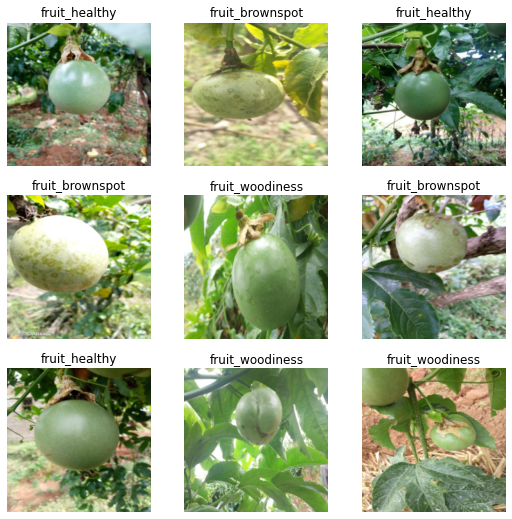

In [ ]:
# Create the dataloaders
dls = ImageDataLoaders.from_df(train, fn_col='fn', label_col='class', suff='.jpg', item_tfms=Resize(224))
dls.show_batch()

# Quick Model

No fancy training here - this only took a minute, just enough time for me to organise my previous cells a little :)

In [ ]:
learn = cnn_learner(dls, densenet169, metrics=[error_rate,accuracy])
learn.fine_tune(15)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.868467,0.260239,0.096463,0.903537,04:26


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.171535,0.179572,0.057878,0.942122,00:22
1,0.092567,0.109164,0.045016,0.954984,00:21
2,0.062439,0.096370,0.035370,0.964630,00:21
3,0.040803,0.083646,0.032154,0.967846,00:22
4,0.029848,0.083583,0.025723,0.974277,00:22
5,0.025622,0.111477,0.028939,0.971061,00:21
6,0.028342,0.129558,0.028939,0.971061,00:22
7,0.030065,0.136040,0.028939,0.971061,00:22
8,0.025956,0.095971,0.032154,0.967846,00:22
9,0.020963,0.082334,0.019293,0.980707,00:22


# Preds on test set

I didn't read the info page at all, so my first sub consisted of probabilities. The score of 0 was enough for me to re-evaluate and realize they want a ranked list of predictions. np.argsort to the rescue :) The way I've done it here isn't the most efficient but who cares - it runs and we can get a submission on the leaderboard asap!

EDIT: I had to come back and fix this - I missed that the row order differs between test and sample sub. 

In [ ]:
preds = learn.get_preds(dl=dls.test_dl(test)) # Getting the predicted probabilities

In [ ]:
# Checking the format
ss = pd.read_csv('passion_Sample_submission.csv')
ss.head(2)

,Image_ID,prediction
0,ID_00G8K1V3,NaN
1,ID_00ZJEEK3,NaN


In [ ]:
preds[0][0], np.argsort(preds[0])[0] # We have probs and then index if they were sorted (low to high)

(tensor([5.4642e-09, 1.0000e+00, 1.8639e-09]), tensor([2, 0, 1]))

In [ ]:
learn.dls.vocab # The labels in the order used by the model (alphabetical)

['fruit_brownspot', 'fruit_healthy', 'fruit_woodiness']

In [ ]:
# Need to make sure order is right - note staring with the highest prob
test['prediction1'] = [learn.dls.vocab[p[2]] for p in np.argsort(preds[0])]
test['prediction2'] = [learn.dls.vocab[p[1]] for p in np.argsort(preds[0])]
test['prediction3'] = [learn.dls.vocab[p[0]] for p in np.argsort(preds[0])]
test.head()

,Image_ID,fn,prediction1,prediction2,prediction3
0,ID_00G8K1V3,Images/ID_00G8K1V3,fruit_healthy,fruit_brownspot,fruit_woodiness
1,ID_00ZJEEK3,Images/ID_00ZJEEK3,fruit_healthy,fruit_brownspot,fruit_woodiness
2,ID_058OQ45J,Images/ID_058OQ45J,fruit_healthy,fruit_woodiness,fruit_brownspot
3,ID_06EXUMWA,Images/ID_06EXUMWA,fruit_woodiness,fruit_healthy,fruit_brownspot
4,ID_08K42EBS,Images/ID_08K42EBS,fruit_healthy,fruit_brownspot,fruit_woodiness


In [ ]:
# Merging them into ss
ss = pd.merge(ss['Image_ID'], test[['Image_ID', 'prediction1']])#, 'prediction2', 'prediction3']], how='left', on='Image_ID')
ss.head()

,Image_ID,prediction1
0,ID_00G8K1V3,fruit_healthy
1,ID_00ZJEEK3,fruit_healthy
2,ID_058OQ45J,fruit_healthy
3,ID_06EXUMWA,fruit_woodiness
4,ID_08K42EBS,fruit_healthy


In [ ]:
ss.to_csv('passion_prediction1_densenet169_3.csv', index=False) # save and submit - this got 0.988 on the public LB!

# Where next?

This model gives me a feel for the task. But what would one do next? More training? Here are some (uninformed) suggestions:
- Explore the data. Plotting the top losses in the models validation set might reveal something useful.
- Actually read the challenge to find out more about the labelling and those bounding box annotations
- Extend this by drawing the aforementioned bounding boxes over the images to see what they look like. Maybe clip the images to the boxes, or maybe leave just a small margin.
- Everything is very...green in these pics. Perhaps we can do a color transform to bring out the features more clearly?
- ... after playing around, we can then start trying more training, bigger models etc. But don't do that until you've seen what gains you can get by better treatment of the data (cropping etc)!